In [1]:
import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

In [2]:
from util import getHash

name = 'FNN-Classification-Simple'

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['targets']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [2048,1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 10,
}

HASH = getHash(name,[architecture,props])
print(HASH)

FNN-Classification-Simple-sigmoid_100000_2048_1024_512_256_128_0001_CCE_10_1_1_0_1_0_e_e_0_1_1_connectivity_data_norm_b25_targets_t1_native_k5_b25_t1_0_42_n_native_08_0_05_06


In [3]:
from DataGeneratorClassificationFNN import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1919620, 834)
(1919620, 8)
validation
(288502, 834)
(288502, 8)
test
(221128, 834)
(221128, 8)


In [4]:
from ModelClassificationFNN import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/'+props['space']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASH),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 834)]             0         


 dense (Dense)               (None, 2048)              1710080   


 dense_1 (Dense)             (None, 1024)              2098176   


 dense_2 (Dense)             (None, 512)               524800    


 dense_3 (Dense)             (None, 256)               131328    


 dense_4 (Dense)             (None, 128)               32896     


 dense_5 (Dense)             (None, 8)                 1032      


Total params: 4498312 (17.16 MB)


Trainable params: 4498312 (17.16 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASH)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASH), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASH))

Epoch 1/10000


 1/20 [>.............................] - ETA: 3:23 - loss: 2.1862 - STD: 0.0532 - MAE: 0.2191

 2/20 [==>...........................] - ETA: 7s - loss: 2.1363 - STD: 0.0331 - MAE: 0.2189  

 3/20 [===>..........................] - ETA: 7s - loss: 2.1220 - STD: 0.0313 - MAE: 0.2188

 4/20 [=====>........................] - ETA: 6s - loss: 2.1194 - STD: 0.0330 - MAE: 0.2187

 5/20 [======>.......................] - ETA: 6s - loss: 2.1174 - STD: 0.0335 - MAE: 0.2186

 6/20 [========>.....................] - ETA: 5s - loss: 2.1136 - STD: 0.0324 - MAE: 0.2186

 7/20 [=========>....................] - ETA: 5s - loss: 2.1096 - STD: 0.0302 - MAE: 0.2186

 8/20 [===========>..................] - ETA: 5s - loss: 2.1059 - STD: 0.0275 - MAE: 0.2186

 9/20 [============>.................] - ETA: 4s - loss: 2.1031 - STD: 0.0253 - MAE: 0.2186

10/20 [==============>...............] - ETA: 4s - loss: 2.1012 - STD: 0.0240 - MAE: 0.2186

11/20 [===============>..............] - ETA: 3s - loss: 2.1000 - STD: 0.0234 - MAE: 0.2187

12/20 [=================>............] - ETA: 3s - loss: 2.0991 - STD: 0.0228 - MAE: 0.2187

13/20 [==================>...........] - ETA: 2s - loss: 2.0982 - STD: 0.0222 - MAE: 0.2187

14/20 [====================>.........] - ETA: 3s - loss: 2.0980 - STD: 0.0215 - MAE: 0.2187

15/20 [=====================>........] - ETA: 3s - loss: 2.0968 - STD: 0.0206 - MAE: 0.2187

16/20 [=======================>......] - ETA: 2s - loss: 2.0956 - STD: 0.0196 - MAE: 0.2187

17/20 [========================>.....] - ETA: 1s - loss: 2.0946 - STD: 0.0189 - MAE: 0.2187

18/20 [==========================>...] - ETA: 1s - loss: 2.0937 - STD: 0.0185 - MAE: 0.2187

19/20 [===========================>..] - ETA: 0s - loss: 2.0930 - STD: 0.0183 - MAE: 0.2187

20/20 [==============================] - ETA: 0s - loss: 2.0924 - STD: 0.0181 - MAE: 0.2187

20/20 [==============================] - 27s 841ms/step - loss: 2.0924 - STD: 0.0181 - MAE: 0.2187 - val_loss: 2.0795 - val_STD: 0.0157 - val_MAE: 0.2185


Epoch 2/10000


 1/20 [>.............................] - ETA: 17s - loss: 2.0815 - STD: 0.0157 - MAE: 0.2186

 2/20 [==>...........................] - ETA: 8s - loss: 2.0814 - STD: 0.0151 - MAE: 0.2186 

 3/20 [===>..........................] - ETA: 7s - loss: 2.0811 - STD: 0.0142 - MAE: 0.2186

 4/20 [=====>........................] - ETA: 6s - loss: 2.0806 - STD: 0.0130 - MAE: 0.2186

 5/20 [======>.......................] - ETA: 6s - loss: 2.0801 - STD: 0.0118 - MAE: 0.2186

 6/20 [========>.....................] - ETA: 5s - loss: 2.0800 - STD: 0.0108 - MAE: 0.2186

 7/20 [=========>....................] - ETA: 4s - loss: 2.0798 - STD: 0.0101 - MAE: 0.2186

 8/20 [===========>..................] - ETA: 4s - loss: 2.0797 - STD: 0.0097 - MAE: 0.2186

 9/20 [============>.................] - ETA: 4s - loss: 2.0797 - STD: 0.0095 - MAE: 0.2187

10/20 [==============>...............] - ETA: 3s - loss: 2.0797 - STD: 0.0093 - MAE: 0.2187

11/20 [===============>..............] - ETA: 3s - loss: 2.0796 - STD: 0.0091 - MAE: 0.2187

12/20 [=================>............] - ETA: 3s - loss: 2.0796 - STD: 0.0089 - MAE: 0.2187

13/20 [==================>...........] - ETA: 2s - loss: 2.0795 - STD: 0.0087 - MAE: 0.2187

14/20 [====================>.........] - ETA: 2s - loss: 2.0794 - STD: 0.0086 - MAE: 0.2187

15/20 [=====================>........] - ETA: 1s - loss: 2.0793 - STD: 0.0085 - MAE: 0.2187

16/20 [=======================>......] - ETA: 1s - loss: 2.0792 - STD: 0.0084 - MAE: 0.2187

17/20 [========================>.....] - ETA: 1s - loss: 2.0792 - STD: 0.0085 - MAE: 0.2187

18/20 [==========================>...] - ETA: 0s - loss: 2.0792 - STD: 0.0085 - MAE: 0.2187

19/20 [===========================>..] - ETA: 0s - loss: 2.0791 - STD: 0.0086 - MAE: 0.2187

20/20 [==============================] - ETA: 0s - loss: 2.0791 - STD: 0.0086 - MAE: 0.2187

20/20 [==============================] - 10s 475ms/step - loss: 2.0791 - STD: 0.0086 - MAE: 0.2187 - val_loss: 2.0770 - val_STD: 0.0089 - val_MAE: 0.2186


Epoch 3/10000


 1/20 [>.............................] - ETA: 13s - loss: 2.0785 - STD: 0.0088 - MAE: 0.2186

 2/20 [==>...........................] - ETA: 1s - loss: 2.0786 - STD: 0.0084 - MAE: 0.2187 

 3/20 [===>..........................] - ETA: 4s - loss: 2.0784 - STD: 0.0078 - MAE: 0.2187

 4/20 [=====>........................] - ETA: 4s - loss: 2.0782 - STD: 0.0073 - MAE: 0.2187

 5/20 [======>.......................] - ETA: 4s - loss: 2.0783 - STD: 0.0070 - MAE: 0.2187

 6/20 [========>.....................] - ETA: 4s - loss: 2.0783 - STD: 0.0069 - MAE: 0.2187

 7/20 [=========>....................] - ETA: 4s - loss: 2.0783 - STD: 0.0068 - MAE: 0.2187

 8/20 [===========>..................] - ETA: 4s - loss: 2.0783 - STD: 0.0067 - MAE: 0.2187

 9/20 [============>.................] - ETA: 3s - loss: 2.0783 - STD: 0.0067 - MAE: 0.2187

10/20 [==============>...............] - ETA: 3s - loss: 2.0782 - STD: 0.0067 - MAE: 0.2187

11/20 [===============>..............] - ETA: 3s - loss: 2.0782 - STD: 0.0067 - MAE: 0.2187

12/20 [=================>............] - ETA: 3s - loss: 2.0782 - STD: 0.0068 - MAE: 0.2187

13/20 [==================>...........] - ETA: 2s - loss: 2.0782 - STD: 0.0069 - MAE: 0.2187

14/20 [====================>.........] - ETA: 2s - loss: 2.0782 - STD: 0.0069 - MAE: 0.2187

15/20 [=====================>........] - ETA: 1s - loss: 2.0782 - STD: 0.0070 - MAE: 0.2187

16/20 [=======================>......] - ETA: 1s - loss: 2.0782 - STD: 0.0070 - MAE: 0.2187

17/20 [========================>.....] - ETA: 1s - loss: 2.0782 - STD: 0.0071 - MAE: 0.2187

18/20 [==========================>...] - ETA: 0s - loss: 2.0781 - STD: 0.0071 - MAE: 0.2187

19/20 [===========================>..] - ETA: 0s - loss: 2.0781 - STD: 0.0071 - MAE: 0.2187

20/20 [==============================] - ETA: 0s - loss: 2.0781 - STD: 0.0071 - MAE: 0.2187

20/20 [==============================] - 10s 468ms/step - loss: 2.0781 - STD: 0.0071 - MAE: 0.2187 - val_loss: 2.0768 - val_STD: 0.0066 - val_MAE: 0.2186


Epoch 4/10000


 1/20 [>.............................] - ETA: 16s - loss: 2.0779 - STD: 0.0066 - MAE: 0.2187

 2/20 [==>...........................] - ETA: 7s - loss: 2.0778 - STD: 0.0063 - MAE: 0.2187 

 3/20 [===>..........................] - ETA: 7s - loss: 2.0778 - STD: 0.0060 - MAE: 0.2187

 4/20 [=====>........................] - ETA: 6s - loss: 2.0777 - STD: 0.0059 - MAE: 0.2187

 5/20 [======>.......................] - ETA: 6s - loss: 2.0777 - STD: 0.0060 - MAE: 0.2187

 6/20 [========>.....................] - ETA: 5s - loss: 2.0778 - STD: 0.0061 - MAE: 0.2187

 7/20 [=========>....................] - ETA: 5s - loss: 2.0777 - STD: 0.0062 - MAE: 0.2187

 8/20 [===========>..................] - ETA: 5s - loss: 2.0776 - STD: 0.0063 - MAE: 0.2187

 9/20 [============>.................] - ETA: 4s - loss: 2.0776 - STD: 0.0063 - MAE: 0.2187

10/20 [==============>...............] - ETA: 4s - loss: 2.0775 - STD: 0.0064 - MAE: 0.2186

11/20 [===============>..............] - ETA: 3s - loss: 2.0774 - STD: 0.0065 - MAE: 0.2186

12/20 [=================>............] - ETA: 3s - loss: 2.0773 - STD: 0.0066 - MAE: 0.2186

13/20 [==================>...........] - ETA: 2s - loss: 2.0772 - STD: 0.0067 - MAE: 0.2186

14/20 [====================>.........] - ETA: 2s - loss: 2.0771 - STD: 0.0068 - MAE: 0.2186

15/20 [=====================>........] - ETA: 2s - loss: 2.0769 - STD: 0.0068 - MAE: 0.2186

16/20 [=======================>......] - ETA: 1s - loss: 2.0768 - STD: 0.0068 - MAE: 0.2186

17/20 [========================>.....] - ETA: 1s - loss: 2.0766 - STD: 0.0068 - MAE: 0.2186

18/20 [==========================>...] - ETA: 0s - loss: 2.0763 - STD: 0.0068 - MAE: 0.2186

19/20 [===========================>..] - ETA: 0s - loss: 2.0762 - STD: 0.0068 - MAE: 0.2186

20/20 [==============================] - ETA: 0s - loss: 2.0758 - STD: 0.0068 - MAE: 0.2186

20/20 [==============================] - 10s 462ms/step - loss: 2.0758 - STD: 0.0068 - MAE: 0.2186 - val_loss: 2.0664 - val_STD: 0.0071 - val_MAE: 0.2183


Epoch 5/10000


 1/20 [>.............................] - ETA: 14s - loss: 2.0657 - STD: 0.0071 - MAE: 0.2183

 2/20 [==>...........................] - ETA: 7s - loss: 2.0642 - STD: 0.0076 - MAE: 0.2182 

 3/20 [===>..........................] - ETA: 6s - loss: 2.0623 - STD: 0.0082 - MAE: 0.2181

 4/20 [=====>........................] - ETA: 4s - loss: 2.0621 - STD: 0.0094 - MAE: 0.2181

 5/20 [======>.......................] - ETA: 4s - loss: 2.0599 - STD: 0.0104 - MAE: 0.2180

 6/20 [========>.....................] - ETA: 4s - loss: 2.0565 - STD: 0.0110 - MAE: 0.2179

 7/20 [=========>....................] - ETA: 4s - loss: 2.0546 - STD: 0.0122 - MAE: 0.2178

 8/20 [===========>..................] - ETA: 4s - loss: 2.0519 - STD: 0.0131 - MAE: 0.2177

 9/20 [============>.................] - ETA: 3s - loss: 2.0481 - STD: 0.0139 - MAE: 0.2176

10/20 [==============>...............] - ETA: 3s - loss: 2.0456 - STD: 0.0154 - MAE: 0.2175

11/20 [===============>..............] - ETA: 3s - loss: 2.0434 - STD: 0.0167 - MAE: 0.2173

12/20 [=================>............] - ETA: 2s - loss: 2.0392 - STD: 0.0179 - MAE: 0.2172

13/20 [==================>...........] - ETA: 2s - loss: 2.0374 - STD: 0.0197 - MAE: 0.2170

14/20 [====================>.........] - ETA: 2s - loss: 2.0350 - STD: 0.0211 - MAE: 0.2169

15/20 [=====================>........] - ETA: 1s - loss: 2.0312 - STD: 0.0223 - MAE: 0.2167

16/20 [=======================>......] - ETA: 1s - loss: 2.0306 - STD: 0.0243 - MAE: 0.2165

17/20 [========================>.....] - ETA: 1s - loss: 2.0269 - STD: 0.0255 - MAE: 0.2163

18/20 [==========================>...] - ETA: 0s - loss: 2.0248 - STD: 0.0268 - MAE: 0.2162

19/20 [===========================>..] - ETA: 0s - loss: 2.0218 - STD: 0.0282 - MAE: 0.2160

20/20 [==============================] - ETA: 0s - loss: 2.0192 - STD: 0.0296 - MAE: 0.2158

20/20 [==============================] - 9s 456ms/step - loss: 2.0192 - STD: 0.0296 - MAE: 0.2158 - val_loss: 1.9972 - val_STD: 0.0544 - val_MAE: 0.2133


Epoch 6/10000


 1/20 [>.............................] - ETA: 15s - loss: 1.9776 - STD: 0.0536 - MAE: 0.2128

 2/20 [==>...........................] - ETA: 8s - loss: 1.9680 - STD: 0.0546 - MAE: 0.2124 

 3/20 [===>..........................] - ETA: 7s - loss: 1.9707 - STD: 0.0576 - MAE: 0.2121

 4/20 [=====>........................] - ETA: 6s - loss: 1.9668 - STD: 0.0579 - MAE: 0.2120

 5/20 [======>.......................] - ETA: 6s - loss: 1.9670 - STD: 0.0580 - MAE: 0.2120

 6/20 [========>.....................] - ETA: 5s - loss: 1.9646 - STD: 0.0587 - MAE: 0.2118

 7/20 [=========>....................] - ETA: 5s - loss: 1.9640 - STD: 0.0595 - MAE: 0.2117

 8/20 [===========>..................] - ETA: 5s - loss: 1.9629 - STD: 0.0597 - MAE: 0.2117

 9/20 [============>.................] - ETA: 4s - loss: 1.9618 - STD: 0.0598 - MAE: 0.2116

10/20 [==============>...............] - ETA: 4s - loss: 1.9610 - STD: 0.0604 - MAE: 0.2115

11/20 [===============>..............] - ETA: 3s - loss: 1.9596 - STD: 0.0607 - MAE: 0.2114

12/20 [=================>............] - ETA: 3s - loss: 1.9590 - STD: 0.0608 - MAE: 0.2114

13/20 [==================>...........] - ETA: 2s - loss: 1.9587 - STD: 0.0610 - MAE: 0.2114

14/20 [====================>.........] - ETA: 2s - loss: 1.9581 - STD: 0.0614 - MAE: 0.2113

15/20 [=====================>........] - ETA: 1s - loss: 1.9569 - STD: 0.0615 - MAE: 0.2113

16/20 [=======================>......] - ETA: 1s - loss: 1.9562 - STD: 0.0615 - MAE: 0.2112

17/20 [========================>.....] - ETA: 1s - loss: 1.9552 - STD: 0.0616 - MAE: 0.2112

18/20 [==========================>...] - ETA: 0s - loss: 1.9549 - STD: 0.0618 - MAE: 0.2112

19/20 [===========================>..] - ETA: 0s - loss: 1.9540 - STD: 0.0618 - MAE: 0.2111

20/20 [==============================] - ETA: 0s - loss: 1.9534 - STD: 0.0618 - MAE: 0.2111

20/20 [==============================] - 10s 473ms/step - loss: 1.9534 - STD: 0.0618 - MAE: 0.2111 - val_loss: 1.9862 - val_STD: 0.0670 - val_MAE: 0.2114


Epoch 7/10000


 1/20 [>.............................] - ETA: 12s - loss: 1.9406 - STD: 0.0638 - MAE: 0.2105

 2/20 [==>...........................] - ETA: 8s - loss: 1.9398 - STD: 0.0639 - MAE: 0.2105 

 3/20 [===>..........................] - ETA: 7s - loss: 1.9388 - STD: 0.0635 - MAE: 0.2105

 4/20 [=====>........................] - ETA: 6s - loss: 1.9386 - STD: 0.0632 - MAE: 0.2105

 5/20 [======>.......................] - ETA: 6s - loss: 1.9383 - STD: 0.0633 - MAE: 0.2105

 6/20 [========>.....................] - ETA: 5s - loss: 1.9376 - STD: 0.0633 - MAE: 0.2105

 7/20 [=========>....................] - ETA: 5s - loss: 1.9372 - STD: 0.0631 - MAE: 0.2105

 8/20 [===========>..................] - ETA: 4s - loss: 1.9363 - STD: 0.0632 - MAE: 0.2105

 9/20 [============>.................] - ETA: 4s - loss: 1.9363 - STD: 0.0633 - MAE: 0.2104

10/20 [==============>...............] - ETA: 3s - loss: 1.9358 - STD: 0.0634 - MAE: 0.2104

11/20 [===============>..............] - ETA: 3s - loss: 1.9350 - STD: 0.0634 - MAE: 0.2104

12/20 [=================>............] - ETA: 3s - loss: 1.9343 - STD: 0.0635 - MAE: 0.2103

13/20 [==================>...........] - ETA: 2s - loss: 1.9337 - STD: 0.0636 - MAE: 0.2103

14/20 [====================>.........] - ETA: 2s - loss: 1.9334 - STD: 0.0637 - MAE: 0.2103

15/20 [=====================>........] - ETA: 1s - loss: 1.9328 - STD: 0.0638 - MAE: 0.2103

16/20 [=======================>......] - ETA: 1s - loss: 1.9323 - STD: 0.0639 - MAE: 0.2102

17/20 [========================>.....] - ETA: 1s - loss: 1.9317 - STD: 0.0640 - MAE: 0.2102

18/20 [==========================>...] - ETA: 0s - loss: 1.9310 - STD: 0.0641 - MAE: 0.2102

19/20 [===========================>..] - ETA: 0s - loss: 1.9303 - STD: 0.0642 - MAE: 0.2101

20/20 [==============================] - ETA: 0s - loss: 1.9298 - STD: 0.0643 - MAE: 0.2101

20/20 [==============================] - 9s 460ms/step - loss: 1.9298 - STD: 0.0643 - MAE: 0.2101 - val_loss: 1.9674 - val_STD: 0.0696 - val_MAE: 0.2104


Epoch 8/10000


 1/20 [>.............................] - ETA: 2s - loss: 1.9272 - STD: 0.0665 - MAE: 0.2096

 2/20 [==>...........................] - ETA: 13s - loss: 1.9156 - STD: 0.0669 - MAE: 0.2094

 3/20 [===>..........................] - ETA: 9s - loss: 1.9150 - STD: 0.0672 - MAE: 0.2092 

 4/20 [=====>........................] - ETA: 8s - loss: 1.9144 - STD: 0.0673 - MAE: 0.2092

 5/20 [======>.......................] - ETA: 7s - loss: 1.9136 - STD: 0.0675 - MAE: 0.2091

 6/20 [========>.....................] - ETA: 6s - loss: 1.9131 - STD: 0.0677 - MAE: 0.2091

 7/20 [=========>....................] - ETA: 6s - loss: 1.9128 - STD: 0.0678 - MAE: 0.2090

 8/20 [===========>..................] - ETA: 5s - loss: 1.9115 - STD: 0.0679 - MAE: 0.2089

 9/20 [============>.................] - ETA: 4s - loss: 1.9112 - STD: 0.0681 - MAE: 0.2089

10/20 [==============>...............] - ETA: 4s - loss: 1.9106 - STD: 0.0683 - MAE: 0.2089

11/20 [===============>..............] - ETA: 3s - loss: 1.9098 - STD: 0.0685 - MAE: 0.2088

12/20 [=================>............] - ETA: 3s - loss: 1.9094 - STD: 0.0687 - MAE: 0.2087

13/20 [==================>...........] - ETA: 3s - loss: 1.9090 - STD: 0.0688 - MAE: 0.2087

14/20 [====================>.........] - ETA: 2s - loss: 1.9081 - STD: 0.0691 - MAE: 0.2086

15/20 [=====================>........] - ETA: 2s - loss: 1.9072 - STD: 0.0693 - MAE: 0.2086

16/20 [=======================>......] - ETA: 1s - loss: 1.9065 - STD: 0.0695 - MAE: 0.2085

17/20 [========================>.....] - ETA: 1s - loss: 1.9057 - STD: 0.0697 - MAE: 0.2084

18/20 [==========================>...] - ETA: 0s - loss: 1.9049 - STD: 0.0700 - MAE: 0.2084

19/20 [===========================>..] - ETA: 0s - loss: 1.9042 - STD: 0.0702 - MAE: 0.2083

20/20 [==============================] - ETA: 0s - loss: 1.9035 - STD: 0.0704 - MAE: 0.2083

20/20 [==============================] - 9s 486ms/step - loss: 1.9035 - STD: 0.0704 - MAE: 0.2083 - val_loss: 1.9548 - val_STD: 0.0782 - val_MAE: 0.2084


Epoch 9/10000


 1/20 [>.............................] - ETA: 15s - loss: 1.8904 - STD: 0.0760 - MAE: 0.2069

 2/20 [==>...........................] - ETA: 6s - loss: 1.8912 - STD: 0.0755 - MAE: 0.2070 

 3/20 [===>..........................] - ETA: 6s - loss: 1.8919 - STD: 0.0761 - MAE: 0.2069

 4/20 [=====>........................] - ETA: 6s - loss: 1.8930 - STD: 0.0760 - MAE: 0.2070

 5/20 [======>.......................] - ETA: 6s - loss: 1.8925 - STD: 0.0764 - MAE: 0.2069

 6/20 [========>.....................] - ETA: 5s - loss: 1.8921 - STD: 0.0763 - MAE: 0.2069

 7/20 [=========>....................] - ETA: 5s - loss: 1.8908 - STD: 0.0763 - MAE: 0.2069

 8/20 [===========>..................] - ETA: 4s - loss: 1.8898 - STD: 0.0764 - MAE: 0.2068

 9/20 [============>.................] - ETA: 4s - loss: 1.8896 - STD: 0.0763 - MAE: 0.2068

10/20 [==============>...............] - ETA: 4s - loss: 1.8899 - STD: 0.0764 - MAE: 0.2068

11/20 [===============>..............] - ETA: 3s - loss: 1.8911 - STD: 0.0763 - MAE: 0.2069

12/20 [=================>............] - ETA: 3s - loss: 1.8913 - STD: 0.0765 - MAE: 0.2069

13/20 [==================>...........] - ETA: 2s - loss: 1.8907 - STD: 0.0764 - MAE: 0.2069

14/20 [====================>.........] - ETA: 2s - loss: 1.8897 - STD: 0.0765 - MAE: 0.2068

15/20 [=====================>........] - ETA: 2s - loss: 1.8892 - STD: 0.0766 - MAE: 0.2068

16/20 [=======================>......] - ETA: 1s - loss: 1.8891 - STD: 0.0765 - MAE: 0.2068

17/20 [========================>.....] - ETA: 1s - loss: 1.8884 - STD: 0.0766 - MAE: 0.2068

18/20 [==========================>...] - ETA: 0s - loss: 1.8883 - STD: 0.0766 - MAE: 0.2068

19/20 [===========================>..] - ETA: 0s - loss: 1.8876 - STD: 0.0765 - MAE: 0.2067

20/20 [==============================] - ETA: 0s - loss: 1.8872 - STD: 0.0767 - MAE: 0.2067

20/20 [==============================] - 9s 448ms/step - loss: 1.8872 - STD: 0.0767 - MAE: 0.2067 - val_loss: 1.9193 - val_STD: 0.0772 - val_MAE: 0.2075


Epoch 10/10000


 1/20 [>.............................] - ETA: 17s - loss: 1.8916 - STD: 0.0757 - MAE: 0.2071

 2/20 [==>...........................] - ETA: 7s - loss: 1.8827 - STD: 0.0769 - MAE: 0.2066 

 3/20 [===>..........................] - ETA: 6s - loss: 1.8772 - STD: 0.0771 - MAE: 0.2064

 4/20 [=====>........................] - ETA: 6s - loss: 1.8756 - STD: 0.0773 - MAE: 0.2063

 5/20 [======>.......................] - ETA: 5s - loss: 1.8748 - STD: 0.0779 - MAE: 0.2062

 6/20 [========>.....................] - ETA: 5s - loss: 1.8748 - STD: 0.0780 - MAE: 0.2062

 7/20 [=========>....................] - ETA: 5s - loss: 1.8737 - STD: 0.0782 - MAE: 0.2061

 8/20 [===========>..................] - ETA: 4s - loss: 1.8730 - STD: 0.0784 - MAE: 0.2061

 9/20 [============>.................] - ETA: 3s - loss: 1.8730 - STD: 0.0783 - MAE: 0.2061

10/20 [==============>...............] - ETA: 3s - loss: 1.8726 - STD: 0.0785 - MAE: 0.2060

11/20 [===============>..............] - ETA: 3s - loss: 1.8721 - STD: 0.0785 - MAE: 0.2060

12/20 [=================>............] - ETA: 2s - loss: 1.8715 - STD: 0.0787 - MAE: 0.2060

13/20 [==================>...........] - ETA: 2s - loss: 1.8707 - STD: 0.0787 - MAE: 0.2060

14/20 [====================>.........] - ETA: 2s - loss: 1.8702 - STD: 0.0788 - MAE: 0.2059

15/20 [=====================>........] - ETA: 1s - loss: 1.8695 - STD: 0.0789 - MAE: 0.2059

16/20 [=======================>......] - ETA: 1s - loss: 1.8688 - STD: 0.0789 - MAE: 0.2059

17/20 [========================>.....] - ETA: 1s - loss: 1.8683 - STD: 0.0791 - MAE: 0.2058

18/20 [==========================>...] - ETA: 0s - loss: 1.8683 - STD: 0.0791 - MAE: 0.2058

19/20 [===========================>..] - ETA: 0s - loss: 1.8690 - STD: 0.0794 - MAE: 0.2058

20/20 [==============================] - ETA: 0s - loss: 1.8710 - STD: 0.0793 - MAE: 0.2059

20/20 [==============================] - 9s 443ms/step - loss: 1.8710 - STD: 0.0793 - MAE: 0.2059 - val_loss: 1.9401 - val_STD: 0.0844 - val_MAE: 0.2069


Epoch 11/10000


 1/20 [>.............................] - ETA: 13s - loss: 1.8721 - STD: 0.0825 - MAE: 0.2054

 2/20 [==>...........................] - ETA: 7s - loss: 1.8624 - STD: 0.0811 - MAE: 0.2053 

 3/20 [===>..........................] - ETA: 7s - loss: 1.8638 - STD: 0.0803 - MAE: 0.2055

 4/20 [=====>........................] - ETA: 6s - loss: 1.8662 - STD: 0.0810 - MAE: 0.2055

 5/20 [======>.......................] - ETA: 6s - loss: 1.8692 - STD: 0.0804 - MAE: 0.2057

 6/20 [========>.....................] - ETA: 5s - loss: 1.8666 - STD: 0.0804 - MAE: 0.2056

 7/20 [=========>....................] - ETA: 5s - loss: 1.8656 - STD: 0.0804 - MAE: 0.2055

 8/20 [===========>..................] - ETA: 4s - loss: 1.8661 - STD: 0.0801 - MAE: 0.2056

 9/20 [============>.................] - ETA: 4s - loss: 1.8655 - STD: 0.0803 - MAE: 0.2056

10/20 [==============>...............] - ETA: 3s - loss: 1.8651 - STD: 0.0804 - MAE: 0.2055

11/20 [===============>..............] - ETA: 3s - loss: 1.8643 - STD: 0.0803 - MAE: 0.2055

12/20 [=================>............] - ETA: 3s - loss: 1.8640 - STD: 0.0805 - MAE: 0.2054

13/20 [==================>...........] - ETA: 2s - loss: 1.8635 - STD: 0.0805 - MAE: 0.2054

14/20 [====================>.........] - ETA: 2s - loss: 1.8624 - STD: 0.0806 - MAE: 0.2054

15/20 [=====================>........] - ETA: 1s - loss: 1.8613 - STD: 0.0807 - MAE: 0.2053

16/20 [=======================>......] - ETA: 1s - loss: 1.8611 - STD: 0.0807 - MAE: 0.2053

17/20 [========================>.....] - ETA: 1s - loss: 1.8605 - STD: 0.0809 - MAE: 0.2053

18/20 [==========================>...] - ETA: 0s - loss: 1.8598 - STD: 0.0809 - MAE: 0.2053

19/20 [===========================>..] - ETA: 0s - loss: 1.8589 - STD: 0.0810 - MAE: 0.2052

20/20 [==============================] - ETA: 0s - loss: 1.8581 - STD: 0.0811 - MAE: 0.2052

20/20 [==============================] - 9s 453ms/step - loss: 1.8581 - STD: 0.0811 - MAE: 0.2052 - val_loss: 1.8920 - val_STD: 0.0841 - val_MAE: 0.2055


Epoch 12/10000


 1/20 [>.............................] - ETA: 14s - loss: 1.8468 - STD: 0.0829 - MAE: 0.2046

 2/20 [==>...........................] - ETA: 8s - loss: 1.8494 - STD: 0.0841 - MAE: 0.2044 

 3/20 [===>..........................] - ETA: 7s - loss: 1.8520 - STD: 0.0835 - MAE: 0.2046

 4/20 [=====>........................] - ETA: 5s - loss: 1.8520 - STD: 0.0840 - MAE: 0.2045

 5/20 [======>.......................] - ETA: 5s - loss: 1.8526 - STD: 0.0835 - MAE: 0.2046

 6/20 [========>.....................] - ETA: 4s - loss: 1.8516 - STD: 0.0836 - MAE: 0.2046

 7/20 [=========>....................] - ETA: 4s - loss: 1.8501 - STD: 0.0835 - MAE: 0.2045

 8/20 [===========>..................] - ETA: 4s - loss: 1.8488 - STD: 0.0835 - MAE: 0.2045

 9/20 [============>.................] - ETA: 3s - loss: 1.8476 - STD: 0.0836 - MAE: 0.2045

10/20 [==============>...............] - ETA: 3s - loss: 1.8469 - STD: 0.0836 - MAE: 0.2044

11/20 [===============>..............] - ETA: 3s - loss: 1.8472 - STD: 0.0838 - MAE: 0.2044

12/20 [=================>............] - ETA: 2s - loss: 1.8494 - STD: 0.0837 - MAE: 0.2045

13/20 [==================>...........] - ETA: 2s - loss: 1.8513 - STD: 0.0840 - MAE: 0.2045

14/20 [====================>.........] - ETA: 2s - loss: 1.8533 - STD: 0.0838 - MAE: 0.2046

15/20 [=====================>........] - ETA: 1s - loss: 1.8524 - STD: 0.0838 - MAE: 0.2045

16/20 [=======================>......] - ETA: 1s - loss: 1.8515 - STD: 0.0838 - MAE: 0.2045

17/20 [========================>.....] - ETA: 1s - loss: 1.8519 - STD: 0.0837 - MAE: 0.2046

18/20 [==========================>...] - ETA: 0s - loss: 1.8524 - STD: 0.0838 - MAE: 0.2045

19/20 [===========================>..] - ETA: 0s - loss: 1.8520 - STD: 0.0837 - MAE: 0.2045

20/20 [==============================] - ETA: 0s - loss: 1.8512 - STD: 0.0837 - MAE: 0.2045

20/20 [==============================] - 9s 454ms/step - loss: 1.8512 - STD: 0.0837 - MAE: 0.2045 - val_loss: 1.8917 - val_STD: 0.0868 - val_MAE: 0.2050


Epoch 13/10000


 1/20 [>.............................] - ETA: 15s - loss: 1.8497 - STD: 0.0860 - MAE: 0.2041

 2/20 [==>...........................] - ETA: 7s - loss: 1.8536 - STD: 0.0837 - MAE: 0.2046 

 3/20 [===>..........................] - ETA: 6s - loss: 1.8482 - STD: 0.0840 - MAE: 0.2044

 4/20 [=====>........................] - ETA: 6s - loss: 1.8452 - STD: 0.0840 - MAE: 0.2043

 5/20 [======>.......................] - ETA: 5s - loss: 1.8457 - STD: 0.0837 - MAE: 0.2044

 6/20 [========>.....................] - ETA: 5s - loss: 1.8449 - STD: 0.0841 - MAE: 0.2043

 7/20 [=========>....................] - ETA: 5s - loss: 1.8426 - STD: 0.0841 - MAE: 0.2042

 8/20 [===========>..................] - ETA: 4s - loss: 1.8405 - STD: 0.0840 - MAE: 0.2041

 9/20 [============>.................] - ETA: 4s - loss: 1.8392 - STD: 0.0843 - MAE: 0.2040

10/20 [==============>...............] - ETA: 4s - loss: 1.8383 - STD: 0.0843 - MAE: 0.2040

11/20 [===============>..............] - ETA: 3s - loss: 1.8372 - STD: 0.0845 - MAE: 0.2039

12/20 [=================>............] - ETA: 3s - loss: 1.8355 - STD: 0.0846 - MAE: 0.2039

13/20 [==================>...........] - ETA: 2s - loss: 1.8347 - STD: 0.0846 - MAE: 0.2038

14/20 [====================>.........] - ETA: 2s - loss: 1.8345 - STD: 0.0848 - MAE: 0.2038

15/20 [=====================>........] - ETA: 1s - loss: 1.8336 - STD: 0.0848 - MAE: 0.2038

16/20 [=======================>......] - ETA: 1s - loss: 1.8328 - STD: 0.0850 - MAE: 0.2037

17/20 [========================>.....] - ETA: 1s - loss: 1.8317 - STD: 0.0851 - MAE: 0.2037

18/20 [==========================>...] - ETA: 0s - loss: 1.8308 - STD: 0.0852 - MAE: 0.2036

19/20 [===========================>..] - ETA: 0s - loss: 1.8298 - STD: 0.0854 - MAE: 0.2035

20/20 [==============================] - ETA: 0s - loss: 1.8294 - STD: 0.0857 - MAE: 0.2035

20/20 [==============================] - 9s 447ms/step - loss: 1.8294 - STD: 0.0857 - MAE: 0.2035 - val_loss: 1.8849 - val_STD: 0.0903 - val_MAE: 0.2042


Epoch 14/10000


 1/20 [>.............................] - ETA: 14s - loss: 1.8330 - STD: 0.0894 - MAE: 0.2031

 2/20 [==>...........................] - ETA: 7s - loss: 1.8536 - STD: 0.0930 - MAE: 0.2031 

 3/20 [===>..........................] - ETA: 6s - loss: 1.8607 - STD: 0.0924 - MAE: 0.2034

 4/20 [=====>........................] - ETA: 6s - loss: 1.8560 - STD: 0.0925 - MAE: 0.2032

 5/20 [======>.......................] - ETA: 6s - loss: 1.8492 - STD: 0.0924 - MAE: 0.2030

 6/20 [========>.....................] - ETA: 5s - loss: 1.8477 - STD: 0.0918 - MAE: 0.2030

 7/20 [=========>....................] - ETA: 5s - loss: 1.8477 - STD: 0.0918 - MAE: 0.2030

 8/20 [===========>..................] - ETA: 4s - loss: 1.8433 - STD: 0.0914 - MAE: 0.2029

 9/20 [============>.................] - ETA: 4s - loss: 1.8419 - STD: 0.0915 - MAE: 0.2029

10/20 [==============>...............] - ETA: 3s - loss: 1.8433 - STD: 0.0918 - MAE: 0.2029

11/20 [===============>..............] - ETA: 3s - loss: 1.8486 - STD: 0.0913 - MAE: 0.2031

12/20 [=================>............] - ETA: 3s - loss: 1.8464 - STD: 0.0910 - MAE: 0.2031

13/20 [==================>...........] - ETA: 2s - loss: 1.8472 - STD: 0.0911 - MAE: 0.2032

14/20 [====================>.........] - ETA: 2s - loss: 1.8534 - STD: 0.0904 - MAE: 0.2035

15/20 [=====================>........] - ETA: 1s - loss: 1.8507 - STD: 0.0897 - MAE: 0.2035

16/20 [=======================>......] - ETA: 1s - loss: 1.8560 - STD: 0.0898 - MAE: 0.2037

17/20 [========================>.....] - ETA: 1s - loss: 1.8554 - STD: 0.0892 - MAE: 0.2038

18/20 [==========================>...] - ETA: 0s - loss: 1.8564 - STD: 0.0884 - MAE: 0.2039

19/20 [===========================>..] - ETA: 0s - loss: 1.8548 - STD: 0.0881 - MAE: 0.2039

20/20 [==============================] - ETA: 0s - loss: 1.8549 - STD: 0.0880 - MAE: 0.2039

20/20 [==============================] - 9s 445ms/step - loss: 1.8549 - STD: 0.0880 - MAE: 0.2039 - val_loss: 1.8834 - val_STD: 0.0793 - val_MAE: 0.2062


Epoch 15/10000


 1/20 [>.............................] - ETA: 14s - loss: 1.8403 - STD: 0.0786 - MAE: 0.2050

 2/20 [==>...........................] - ETA: 6s - loss: 1.8405 - STD: 0.0796 - MAE: 0.2048 

 3/20 [===>..........................] - ETA: 6s - loss: 1.8397 - STD: 0.0819 - MAE: 0.2044

 4/20 [=====>........................] - ETA: 6s - loss: 1.8346 - STD: 0.0828 - MAE: 0.2041

 5/20 [======>.......................] - ETA: 5s - loss: 1.8357 - STD: 0.0830 - MAE: 0.2042

 6/20 [========>.....................] - ETA: 5s - loss: 1.8311 - STD: 0.0833 - MAE: 0.2040

 7/20 [=========>....................] - ETA: 5s - loss: 1.8315 - STD: 0.0841 - MAE: 0.2038

 8/20 [===========>..................] - ETA: 4s - loss: 1.8285 - STD: 0.0845 - MAE: 0.2037

 9/20 [============>.................] - ETA: 4s - loss: 1.8279 - STD: 0.0847 - MAE: 0.2036

10/20 [==============>...............] - ETA: 3s - loss: 1.8255 - STD: 0.0850 - MAE: 0.2035

11/20 [===============>..............] - ETA: 3s - loss: 1.8249 - STD: 0.0854 - MAE: 0.2034

12/20 [=================>............] - ETA: 3s - loss: 1.8233 - STD: 0.0857 - MAE: 0.2033

13/20 [==================>...........] - ETA: 2s - loss: 1.8226 - STD: 0.0859 - MAE: 0.2032

14/20 [====================>.........] - ETA: 2s - loss: 1.8209 - STD: 0.0861 - MAE: 0.2031

15/20 [=====================>........] - ETA: 1s - loss: 1.8208 - STD: 0.0863 - MAE: 0.2031

16/20 [=======================>......] - ETA: 1s - loss: 1.8194 - STD: 0.0863 - MAE: 0.2030

17/20 [========================>.....] - ETA: 1s - loss: 1.8184 - STD: 0.0864 - MAE: 0.2030

18/20 [==========================>...] - ETA: 0s - loss: 1.8174 - STD: 0.0866 - MAE: 0.2029

19/20 [===========================>..] - ETA: 0s - loss: 1.8167 - STD: 0.0867 - MAE: 0.2028

20/20 [==============================] - ETA: 0s - loss: 1.8154 - STD: 0.0869 - MAE: 0.2028

20/20 [==============================] - 9s 449ms/step - loss: 1.8154 - STD: 0.0869 - MAE: 0.2028 - val_loss: 1.8340 - val_STD: 0.0917 - val_MAE: 0.2023


Epoch 16/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.8043 - STD: 0.0930 - MAE: 0.2013

 2/20 [==>...........................] - ETA: 13s - loss: 1.7918 - STD: 0.0923 - MAE: 0.2012

 3/20 [===>..........................] - ETA: 10s - loss: 1.7940 - STD: 0.0919 - MAE: 0.2012

 4/20 [=====>........................] - ETA: 8s - loss: 1.7950 - STD: 0.0927 - MAE: 0.2011 

 5/20 [======>.......................] - ETA: 7s - loss: 1.7939 - STD: 0.0928 - MAE: 0.2010

 6/20 [========>.....................] - ETA: 6s - loss: 1.7930 - STD: 0.0928 - MAE: 0.2010

 7/20 [=========>....................] - ETA: 6s - loss: 1.7937 - STD: 0.0932 - MAE: 0.2009

 8/20 [===========>..................] - ETA: 5s - loss: 1.7933 - STD: 0.0932 - MAE: 0.2009

 9/20 [============>.................] - ETA: 5s - loss: 1.7924 - STD: 0.0933 - MAE: 0.2009

10/20 [==============>...............] - ETA: 4s - loss: 1.7924 - STD: 0.0935 - MAE: 0.2008

11/20 [===============>..............] - ETA: 4s - loss: 1.7928 - STD: 0.0934 - MAE: 0.2008

12/20 [=================>............] - ETA: 3s - loss: 1.7924 - STD: 0.0936 - MAE: 0.2008

13/20 [==================>...........] - ETA: 3s - loss: 1.7921 - STD: 0.0937 - MAE: 0.2008

14/20 [====================>.........] - ETA: 2s - loss: 1.7919 - STD: 0.0936 - MAE: 0.2008

15/20 [=====================>........] - ETA: 2s - loss: 1.7920 - STD: 0.0938 - MAE: 0.2007

16/20 [=======================>......] - ETA: 1s - loss: 1.7919 - STD: 0.0936 - MAE: 0.2008

17/20 [========================>.....] - ETA: 1s - loss: 1.7914 - STD: 0.0937 - MAE: 0.2007

18/20 [==========================>...] - ETA: 0s - loss: 1.7908 - STD: 0.0937 - MAE: 0.2007

19/20 [===========================>..] - ETA: 0s - loss: 1.7907 - STD: 0.0936 - MAE: 0.2007

20/20 [==============================] - ETA: 0s - loss: 1.7910 - STD: 0.0938 - MAE: 0.2007

20/20 [==============================] - 10s 508ms/step - loss: 1.7910 - STD: 0.0938 - MAE: 0.2007 - val_loss: 1.8446 - val_STD: 0.0911 - val_MAE: 0.2030


Epoch 17/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.7845 - STD: 0.0925 - MAE: 0.2007

 2/20 [==>...........................] - ETA: 12s - loss: 1.7818 - STD: 0.0937 - MAE: 0.2004

 3/20 [===>..........................] - ETA: 9s - loss: 1.7810 - STD: 0.0940 - MAE: 0.2003 

 4/20 [=====>........................] - ETA: 8s - loss: 1.7813 - STD: 0.0939 - MAE: 0.2003

 5/20 [======>.......................] - ETA: 7s - loss: 1.7813 - STD: 0.0946 - MAE: 0.2001

 6/20 [========>.....................] - ETA: 6s - loss: 1.7810 - STD: 0.0944 - MAE: 0.2002

 7/20 [=========>....................] - ETA: 5s - loss: 1.7812 - STD: 0.0949 - MAE: 0.2001

 8/20 [===========>..................] - ETA: 5s - loss: 1.7813 - STD: 0.0948 - MAE: 0.2001

 9/20 [============>.................] - ETA: 4s - loss: 1.7808 - STD: 0.0950 - MAE: 0.2000

10/20 [==============>...............] - ETA: 4s - loss: 1.7803 - STD: 0.0950 - MAE: 0.2000

11/20 [===============>..............] - ETA: 3s - loss: 1.7797 - STD: 0.0950 - MAE: 0.2000

12/20 [=================>............] - ETA: 3s - loss: 1.7793 - STD: 0.0951 - MAE: 0.2000

13/20 [==================>...........] - ETA: 3s - loss: 1.7790 - STD: 0.0950 - MAE: 0.2000

14/20 [====================>.........] - ETA: 2s - loss: 1.7788 - STD: 0.0951 - MAE: 0.2000

15/20 [=====================>........] - ETA: 2s - loss: 1.7788 - STD: 0.0950 - MAE: 0.2000

16/20 [=======================>......] - ETA: 1s - loss: 1.7795 - STD: 0.0954 - MAE: 0.1999

17/20 [========================>.....] - ETA: 1s - loss: 1.7802 - STD: 0.0953 - MAE: 0.2000

18/20 [==========================>...] - ETA: 0s - loss: 1.7818 - STD: 0.0957 - MAE: 0.1999

19/20 [===========================>..] - ETA: 0s - loss: 1.7835 - STD: 0.0955 - MAE: 0.2000

20/20 [==============================] - ETA: 0s - loss: 1.7840 - STD: 0.0958 - MAE: 0.2000

20/20 [==============================] - 10s 492ms/step - loss: 1.7840 - STD: 0.0958 - MAE: 0.2000 - val_loss: 1.8451 - val_STD: 0.0928 - val_MAE: 0.2028


Epoch 18/10000


 1/20 [>.............................] - ETA: 17s - loss: 1.7737 - STD: 0.0937 - MAE: 0.1999

 2/20 [==>...........................] - ETA: 8s - loss: 1.7739 - STD: 0.0933 - MAE: 0.2001 

 3/20 [===>..........................] - ETA: 7s - loss: 1.7763 - STD: 0.0953 - MAE: 0.1998

 4/20 [=====>........................] - ETA: 6s - loss: 1.7779 - STD: 0.0947 - MAE: 0.1999

 5/20 [======>.......................] - ETA: 6s - loss: 1.7757 - STD: 0.0951 - MAE: 0.1998

 6/20 [========>.....................] - ETA: 5s - loss: 1.7747 - STD: 0.0956 - MAE: 0.1996

 7/20 [=========>....................] - ETA: 5s - loss: 1.7752 - STD: 0.0954 - MAE: 0.1997

 8/20 [===========>..................] - ETA: 4s - loss: 1.7754 - STD: 0.0961 - MAE: 0.1996

 9/20 [============>.................] - ETA: 4s - loss: 1.7741 - STD: 0.0960 - MAE: 0.1996

10/20 [==============>...............] - ETA: 4s - loss: 1.7734 - STD: 0.0960 - MAE: 0.1995

11/20 [===============>..............] - ETA: 3s - loss: 1.7730 - STD: 0.0962 - MAE: 0.1995

12/20 [=================>............] - ETA: 3s - loss: 1.7731 - STD: 0.0961 - MAE: 0.1995

13/20 [==================>...........] - ETA: 2s - loss: 1.7727 - STD: 0.0963 - MAE: 0.1995

14/20 [====================>.........] - ETA: 2s - loss: 1.7725 - STD: 0.0963 - MAE: 0.1994

15/20 [=====================>........] - ETA: 1s - loss: 1.7720 - STD: 0.0964 - MAE: 0.1994

16/20 [=======================>......] - ETA: 1s - loss: 1.7714 - STD: 0.0965 - MAE: 0.1993

17/20 [========================>.....] - ETA: 1s - loss: 1.7710 - STD: 0.0965 - MAE: 0.1993

18/20 [==========================>...] - ETA: 0s - loss: 1.7710 - STD: 0.0968 - MAE: 0.1993

19/20 [===========================>..] - ETA: 0s - loss: 1.7712 - STD: 0.0968 - MAE: 0.1993

20/20 [==============================] - ETA: 0s - loss: 1.7721 - STD: 0.0972 - MAE: 0.1992

20/20 [==============================] - 10s 467ms/step - loss: 1.7721 - STD: 0.0972 - MAE: 0.1992 - val_loss: 1.9177 - val_STD: 0.0955 - val_MAE: 0.2046


Epoch 19/10000


 1/20 [>.............................] - ETA: 15s - loss: 1.7915 - STD: 0.0938 - MAE: 0.2005

 2/20 [==>...........................] - ETA: 7s - loss: 1.7876 - STD: 0.0983 - MAE: 0.1996 

 3/20 [===>..........................] - ETA: 7s - loss: 1.7809 - STD: 0.0972 - MAE: 0.1995

 4/20 [=====>........................] - ETA: 6s - loss: 1.7768 - STD: 0.0974 - MAE: 0.1994

 5/20 [======>.......................] - ETA: 6s - loss: 1.7723 - STD: 0.0975 - MAE: 0.1992

 6/20 [========>.....................] - ETA: 6s - loss: 1.7704 - STD: 0.0975 - MAE: 0.1991

 7/20 [=========>....................] - ETA: 5s - loss: 1.7693 - STD: 0.0981 - MAE: 0.1989

 8/20 [===========>..................] - ETA: 4s - loss: 1.7692 - STD: 0.0979 - MAE: 0.1989

 9/20 [============>.................] - ETA: 4s - loss: 1.7695 - STD: 0.0986 - MAE: 0.1988

10/20 [==============>...............] - ETA: 3s - loss: 1.7705 - STD: 0.0983 - MAE: 0.1989

11/20 [===============>..............] - ETA: 3s - loss: 1.7703 - STD: 0.0986 - MAE: 0.1988

12/20 [=================>............] - ETA: 3s - loss: 1.7694 - STD: 0.0985 - MAE: 0.1988

13/20 [==================>...........] - ETA: 2s - loss: 1.7683 - STD: 0.0984 - MAE: 0.1988

14/20 [====================>.........] - ETA: 2s - loss: 1.7674 - STD: 0.0987 - MAE: 0.1987

15/20 [=====================>........] - ETA: 1s - loss: 1.7673 - STD: 0.0984 - MAE: 0.1988

16/20 [=======================>......] - ETA: 1s - loss: 1.7676 - STD: 0.0988 - MAE: 0.1987

17/20 [========================>.....] - ETA: 1s - loss: 1.7679 - STD: 0.0986 - MAE: 0.1988

18/20 [==========================>...] - ETA: 0s - loss: 1.7680 - STD: 0.0989 - MAE: 0.1987

19/20 [===========================>..] - ETA: 0s - loss: 1.7676 - STD: 0.0988 - MAE: 0.1987

20/20 [==============================] - ETA: 0s - loss: 1.7668 - STD: 0.0988 - MAE: 0.1987

20/20 [==============================] - 10s 473ms/step - loss: 1.7668 - STD: 0.0988 - MAE: 0.1987 - val_loss: 1.8535 - val_STD: 0.0980 - val_MAE: 0.2021


Epoch 20/10000


 1/20 [>.............................] - ETA: 16s - loss: 1.7537 - STD: 0.0989 - MAE: 0.1981

 2/20 [==>...........................] - ETA: 8s - loss: 1.7535 - STD: 0.0986 - MAE: 0.1982 

 3/20 [===>..........................] - ETA: 4s - loss: 1.7539 - STD: 0.1000 - MAE: 0.1979

 4/20 [=====>........................] - ETA: 5s - loss: 1.7580 - STD: 0.0991 - MAE: 0.1982

 5/20 [======>.......................] - ETA: 5s - loss: 1.7651 - STD: 0.1013 - MAE: 0.1981

 6/20 [========>.....................] - ETA: 4s - loss: 1.7687 - STD: 0.1003 - MAE: 0.1984

 7/20 [=========>....................] - ETA: 4s - loss: 1.7699 - STD: 0.1009 - MAE: 0.1983

 8/20 [===========>..................] - ETA: 4s - loss: 1.7685 - STD: 0.1003 - MAE: 0.1984

 9/20 [============>.................] - ETA: 4s - loss: 1.7663 - STD: 0.1001 - MAE: 0.1984

10/20 [==============>...............] - ETA: 3s - loss: 1.7657 - STD: 0.1003 - MAE: 0.1983

11/20 [===============>..............] - ETA: 3s - loss: 1.7664 - STD: 0.0998 - MAE: 0.1984

12/20 [=================>............] - ETA: 3s - loss: 1.7669 - STD: 0.1005 - MAE: 0.1983

13/20 [==================>...........] - ETA: 2s - loss: 1.7662 - STD: 0.1003 - MAE: 0.1983

14/20 [====================>.........] - ETA: 2s - loss: 1.7649 - STD: 0.1001 - MAE: 0.1983

15/20 [=====================>........] - ETA: 1s - loss: 1.7644 - STD: 0.1003 - MAE: 0.1983

16/20 [=======================>......] - ETA: 1s - loss: 1.7642 - STD: 0.1001 - MAE: 0.1983

17/20 [========================>.....] - ETA: 1s - loss: 1.7638 - STD: 0.1002 - MAE: 0.1983

18/20 [==========================>...] - ETA: 0s - loss: 1.7629 - STD: 0.1001 - MAE: 0.1983

19/20 [===========================>..] - ETA: 0s - loss: 1.7619 - STD: 0.1001 - MAE: 0.1982

20/20 [==============================] - ETA: 0s - loss: 1.7613 - STD: 0.1002 - MAE: 0.1982

20/20 [==============================] - 10s 479ms/step - loss: 1.7613 - STD: 0.1002 - MAE: 0.1982 - val_loss: 1.9128 - val_STD: 0.1012 - val_MAE: 0.2035


Epoch 21/10000


 1/20 [>.............................] - ETA: 16s - loss: 1.7567 - STD: 0.0976 - MAE: 0.1985

 2/20 [==>...........................] - ETA: 8s - loss: 1.7580 - STD: 0.1016 - MAE: 0.1978 

 3/20 [===>..........................] - ETA: 8s - loss: 1.7570 - STD: 0.1003 - MAE: 0.1980

 4/20 [=====>........................] - ETA: 7s - loss: 1.7546 - STD: 0.1009 - MAE: 0.1978

 5/20 [======>.......................] - ETA: 7s - loss: 1.7528 - STD: 0.1005 - MAE: 0.1978

 6/20 [========>.....................] - ETA: 6s - loss: 1.7512 - STD: 0.1007 - MAE: 0.1977

 7/20 [=========>....................] - ETA: 6s - loss: 1.7504 - STD: 0.1007 - MAE: 0.1977

 8/20 [===========>..................] - ETA: 6s - loss: 1.7498 - STD: 0.1007 - MAE: 0.1977

 9/20 [============>.................] - ETA: 5s - loss: 1.7499 - STD: 0.1013 - MAE: 0.1975

10/20 [==============>...............] - ETA: 4s - loss: 1.7508 - STD: 0.1010 - MAE: 0.1976

11/20 [===============>..............] - ETA: 4s - loss: 1.7540 - STD: 0.1021 - MAE: 0.1975

12/20 [=================>............] - ETA: 3s - loss: 1.7582 - STD: 0.1016 - MAE: 0.1978

13/20 [==================>...........] - ETA: 3s - loss: 1.7609 - STD: 0.1024 - MAE: 0.1977

14/20 [====================>.........] - ETA: 2s - loss: 1.7603 - STD: 0.1020 - MAE: 0.1978

15/20 [=====================>........] - ETA: 2s - loss: 1.7595 - STD: 0.1017 - MAE: 0.1978

16/20 [=======================>......] - ETA: 1s - loss: 1.7601 - STD: 0.1019 - MAE: 0.1978

17/20 [========================>.....] - ETA: 1s - loss: 1.7602 - STD: 0.1016 - MAE: 0.1979

18/20 [==========================>...] - ETA: 0s - loss: 1.7595 - STD: 0.1017 - MAE: 0.1978

19/20 [===========================>..] - ETA: 0s - loss: 1.7587 - STD: 0.1018 - MAE: 0.1978

20/20 [==============================] - ETA: 0s - loss: 1.7591 - STD: 0.1016 - MAE: 0.1978

20/20 [==============================] - 11s 557ms/step - loss: 1.7591 - STD: 0.1016 - MAE: 0.1978 - val_loss: 1.8311 - val_STD: 0.1047 - val_MAE: 0.2002


Epoch 22/10000


 1/20 [>.............................] - ETA: 20s - loss: 1.7660 - STD: 0.1079 - MAE: 0.1969

 2/20 [==>...........................] - ETA: 8s - loss: 1.7544 - STD: 0.1033 - MAE: 0.1973 

 3/20 [===>..........................] - ETA: 7s - loss: 1.7520 - STD: 0.1012 - MAE: 0.1976

 4/20 [=====>........................] - ETA: 5s - loss: 1.7526 - STD: 0.1024 - MAE: 0.1975

 5/20 [======>.......................] - ETA: 5s - loss: 1.7499 - STD: 0.1016 - MAE: 0.1976

 6/20 [========>.....................] - ETA: 5s - loss: 1.7491 - STD: 0.1011 - MAE: 0.1976

 7/20 [=========>....................] - ETA: 5s - loss: 1.7493 - STD: 0.1016 - MAE: 0.1975

 8/20 [===========>..................] - ETA: 4s - loss: 1.7499 - STD: 0.1014 - MAE: 0.1976

 9/20 [============>.................] - ETA: 4s - loss: 1.7482 - STD: 0.1015 - MAE: 0.1975

10/20 [==============>...............] - ETA: 4s - loss: 1.7473 - STD: 0.1016 - MAE: 0.1974

11/20 [===============>..............] - ETA: 3s - loss: 1.7466 - STD: 0.1015 - MAE: 0.1974

12/20 [=================>............] - ETA: 3s - loss: 1.7461 - STD: 0.1019 - MAE: 0.1973

13/20 [==================>...........] - ETA: 3s - loss: 1.7459 - STD: 0.1018 - MAE: 0.1973

14/20 [====================>.........] - ETA: 2s - loss: 1.7449 - STD: 0.1019 - MAE: 0.1973

15/20 [=====================>........] - ETA: 2s - loss: 1.7444 - STD: 0.1020 - MAE: 0.1972

16/20 [=======================>......] - ETA: 1s - loss: 1.7439 - STD: 0.1020 - MAE: 0.1972

17/20 [========================>.....] - ETA: 1s - loss: 1.7436 - STD: 0.1021 - MAE: 0.1972

18/20 [==========================>...] - ETA: 0s - loss: 1.7439 - STD: 0.1020 - MAE: 0.1972

19/20 [===========================>..] - ETA: 0s - loss: 1.7435 - STD: 0.1022 - MAE: 0.1971

20/20 [==============================] - ETA: 0s - loss: 1.7431 - STD: 0.1022 - MAE: 0.1971

20/20 [==============================] - 11s 547ms/step - loss: 1.7431 - STD: 0.1022 - MAE: 0.1971 - val_loss: 1.8750 - val_STD: 0.1072 - val_MAE: 0.2012


Epoch 23/10000


 1/20 [>.............................] - ETA: 18s - loss: 1.7320 - STD: 0.1066 - MAE: 0.1958

 2/20 [==>...........................] - ETA: 9s - loss: 1.7352 - STD: 0.1046 - MAE: 0.1963 

 3/20 [===>..........................] - ETA: 8s - loss: 1.7367 - STD: 0.1051 - MAE: 0.1962

 4/20 [=====>........................] - ETA: 8s - loss: 1.7377 - STD: 0.1041 - MAE: 0.1965

 5/20 [======>.......................] - ETA: 7s - loss: 1.7418 - STD: 0.1059 - MAE: 0.1963

 6/20 [========>.....................] - ETA: 7s - loss: 1.7450 - STD: 0.1048 - MAE: 0.1966

 7/20 [=========>....................] - ETA: 6s - loss: 1.7503 - STD: 0.1058 - MAE: 0.1966

 8/20 [===========>..................] - ETA: 5s - loss: 1.7547 - STD: 0.1047 - MAE: 0.1970

 9/20 [============>.................] - ETA: 5s - loss: 1.7539 - STD: 0.1051 - MAE: 0.1969

10/20 [==============>...............] - ETA: 4s - loss: 1.7517 - STD: 0.1048 - MAE: 0.1968

11/20 [===============>..............] - ETA: 3s - loss: 1.7514 - STD: 0.1042 - MAE: 0.1969

12/20 [=================>............] - ETA: 3s - loss: 1.7538 - STD: 0.1051 - MAE: 0.1968

13/20 [==================>...........] - ETA: 3s - loss: 1.7537 - STD: 0.1046 - MAE: 0.1969

14/20 [====================>.........] - ETA: 2s - loss: 1.7524 - STD: 0.1045 - MAE: 0.1969

15/20 [=====================>........] - ETA: 2s - loss: 1.7512 - STD: 0.1045 - MAE: 0.1969

16/20 [=======================>......] - ETA: 1s - loss: 1.7508 - STD: 0.1043 - MAE: 0.1969

17/20 [========================>.....] - ETA: 1s - loss: 1.7499 - STD: 0.1044 - MAE: 0.1969

18/20 [==========================>...] - ETA: 0s - loss: 1.7486 - STD: 0.1042 - MAE: 0.1968

19/20 [===========================>..] - ETA: 0s - loss: 1.7475 - STD: 0.1042 - MAE: 0.1968

20/20 [==============================] - ETA: 0s - loss: 1.7468 - STD: 0.1043 - MAE: 0.1968

20/20 [==============================] - 11s 514ms/step - loss: 1.7468 - STD: 0.1043 - MAE: 0.1968 - val_loss: 1.9670 - val_STD: 0.1121 - val_MAE: 0.2033


Epoch 24/10000


 1/20 [>.............................] - ETA: 14s - loss: 1.7409 - STD: 0.1012 - MAE: 0.1973

 2/20 [==>...........................] - ETA: 7s - loss: 1.7377 - STD: 0.1043 - MAE: 0.1965 

 3/20 [===>..........................] - ETA: 7s - loss: 1.7371 - STD: 0.1035 - MAE: 0.1966

 4/20 [=====>........................] - ETA: 5s - loss: 1.7365 - STD: 0.1035 - MAE: 0.1965

 5/20 [======>.......................] - ETA: 5s - loss: 1.7343 - STD: 0.1039 - MAE: 0.1964

 6/20 [========>.....................] - ETA: 5s - loss: 1.7336 - STD: 0.1037 - MAE: 0.1964

 7/20 [=========>....................] - ETA: 5s - loss: 1.7345 - STD: 0.1046 - MAE: 0.1962

 8/20 [===========>..................] - ETA: 4s - loss: 1.7356 - STD: 0.1043 - MAE: 0.1963

 9/20 [============>.................] - ETA: 4s - loss: 1.7376 - STD: 0.1052 - MAE: 0.1962

10/20 [==============>...............] - ETA: 4s - loss: 1.7381 - STD: 0.1048 - MAE: 0.1963

11/20 [===============>..............] - ETA: 3s - loss: 1.7381 - STD: 0.1051 - MAE: 0.1963

12/20 [=================>............] - ETA: 3s - loss: 1.7377 - STD: 0.1049 - MAE: 0.1963

13/20 [==================>...........] - ETA: 2s - loss: 1.7363 - STD: 0.1048 - MAE: 0.1963

14/20 [====================>.........] - ETA: 2s - loss: 1.7357 - STD: 0.1049 - MAE: 0.1962

15/20 [=====================>........] - ETA: 2s - loss: 1.7356 - STD: 0.1046 - MAE: 0.1963

16/20 [=======================>......] - ETA: 1s - loss: 1.7366 - STD: 0.1051 - MAE: 0.1962

17/20 [========================>.....] - ETA: 1s - loss: 1.7370 - STD: 0.1050 - MAE: 0.1963

18/20 [==========================>...] - ETA: 0s - loss: 1.7369 - STD: 0.1052 - MAE: 0.1962

19/20 [===========================>..] - ETA: 0s - loss: 1.7365 - STD: 0.1051 - MAE: 0.1962

20/20 [==============================] - ETA: 0s - loss: 1.7356 - STD: 0.1050 - MAE: 0.1962

20/20 [==============================] - 10s 480ms/step - loss: 1.7356 - STD: 0.1050 - MAE: 0.1962 - val_loss: 1.8924 - val_STD: 0.1105 - val_MAE: 0.2010


Epoch 25/10000


 1/20 [>.............................] - ETA: 17s - loss: 1.7251 - STD: 0.1064 - MAE: 0.1955

 2/20 [==>...........................] - ETA: 7s - loss: 1.7299 - STD: 0.1044 - MAE: 0.1961 

 3/20 [===>..........................] - ETA: 7s - loss: 1.7318 - STD: 0.1067 - MAE: 0.1957

 4/20 [=====>........................] - ETA: 6s - loss: 1.7334 - STD: 0.1058 - MAE: 0.1959

 5/20 [======>.......................] - ETA: 6s - loss: 1.7326 - STD: 0.1066 - MAE: 0.1958

 6/20 [========>.....................] - ETA: 6s - loss: 1.7314 - STD: 0.1061 - MAE: 0.1958

 7/20 [=========>....................] - ETA: 5s - loss: 1.7299 - STD: 0.1062 - MAE: 0.1957

 8/20 [===========>..................] - ETA: 5s - loss: 1.7288 - STD: 0.1060 - MAE: 0.1957

 9/20 [============>.................] - ETA: 5s - loss: 1.7279 - STD: 0.1060 - MAE: 0.1957

10/20 [==============>...............] - ETA: 4s - loss: 1.7275 - STD: 0.1062 - MAE: 0.1956

11/20 [===============>..............] - ETA: 4s - loss: 1.7269 - STD: 0.1061 - MAE: 0.1956

12/20 [=================>............] - ETA: 3s - loss: 1.7280 - STD: 0.1068 - MAE: 0.1955

13/20 [==================>...........] - ETA: 3s - loss: 1.7309 - STD: 0.1064 - MAE: 0.1957

14/20 [====================>.........] - ETA: 2s - loss: 1.7372 - STD: 0.1075 - MAE: 0.1957

15/20 [=====================>........] - ETA: 2s - loss: 1.7390 - STD: 0.1069 - MAE: 0.1959

16/20 [=======================>......] - ETA: 1s - loss: 1.7378 - STD: 0.1067 - MAE: 0.1959

17/20 [========================>.....] - ETA: 1s - loss: 1.7379 - STD: 0.1069 - MAE: 0.1959

18/20 [==========================>...] - ETA: 0s - loss: 1.7395 - STD: 0.1064 - MAE: 0.1960

19/20 [===========================>..] - ETA: 0s - loss: 1.7390 - STD: 0.1066 - MAE: 0.1960

20/20 [==============================] - ETA: 0s - loss: 1.7383 - STD: 0.1066 - MAE: 0.1960

20/20 [==============================] - 10s 501ms/step - loss: 1.7383 - STD: 0.1066 - MAE: 0.1960 - val_loss: 2.0336 - val_STD: 0.1178 - val_MAE: 0.2043


Epoch 26/10000


 1/20 [>.............................] - ETA: 19s - loss: 1.7547 - STD: 0.1026 - MAE: 0.1974

 2/20 [==>...........................] - ETA: 7s - loss: 1.7580 - STD: 0.1091 - MAE: 0.1962 

 3/20 [===>..........................] - ETA: 7s - loss: 1.7466 - STD: 0.1072 - MAE: 0.1962

 4/20 [=====>........................] - ETA: 6s - loss: 1.7441 - STD: 0.1056 - MAE: 0.1964

 5/20 [======>.......................] - ETA: 6s - loss: 1.7463 - STD: 0.1068 - MAE: 0.1962

 6/20 [========>.....................] - ETA: 6s - loss: 1.7429 - STD: 0.1059 - MAE: 0.1963

 7/20 [=========>....................] - ETA: 5s - loss: 1.7406 - STD: 0.1052 - MAE: 0.1964

 8/20 [===========>..................] - ETA: 5s - loss: 1.7413 - STD: 0.1057 - MAE: 0.1963

 9/20 [============>.................] - ETA: 4s - loss: 1.7415 - STD: 0.1053 - MAE: 0.1964

10/20 [==============>...............] - ETA: 4s - loss: 1.7395 - STD: 0.1051 - MAE: 0.1963

11/20 [===============>..............] - ETA: 3s - loss: 1.7409 - STD: 0.1056 - MAE: 0.1963

12/20 [=================>............] - ETA: 3s - loss: 1.7419 - STD: 0.1053 - MAE: 0.1964

13/20 [==================>...........] - ETA: 3s - loss: 1.7411 - STD: 0.1057 - MAE: 0.1962

14/20 [====================>.........] - ETA: 2s - loss: 1.7414 - STD: 0.1058 - MAE: 0.1962

15/20 [=====================>........] - ETA: 2s - loss: 1.7420 - STD: 0.1054 - MAE: 0.1963

16/20 [=======================>......] - ETA: 1s - loss: 1.7451 - STD: 0.1063 - MAE: 0.1963

17/20 [========================>.....] - ETA: 1s - loss: 1.7447 - STD: 0.1060 - MAE: 0.1963

18/20 [==========================>...] - ETA: 0s - loss: 1.7460 - STD: 0.1057 - MAE: 0.1964

19/20 [===========================>..] - ETA: 0s - loss: 1.7471 - STD: 0.1058 - MAE: 0.1964

20/20 [==============================] - ETA: 0s - loss: 1.7482 - STD: 0.1057 - MAE: 0.1965

20/20 [==============================] - 10s 485ms/step - loss: 1.7482 - STD: 0.1057 - MAE: 0.1965 - val_loss: 1.9693 - val_STD: 0.1105 - val_MAE: 0.2035


Epoch 27/10000


 1/20 [>.............................] - ETA: 13s - loss: 1.7321 - STD: 0.0985 - MAE: 0.1974

 2/20 [==>...........................] - ETA: 7s - loss: 1.7597 - STD: 0.1028 - MAE: 0.1975 

 3/20 [===>..........................] - ETA: 7s - loss: 1.7533 - STD: 0.1017 - MAE: 0.1975

 4/20 [=====>........................] - ETA: 7s - loss: 1.7530 - STD: 0.1033 - MAE: 0.1972

 5/20 [======>.......................] - ETA: 6s - loss: 1.7509 - STD: 0.1044 - MAE: 0.1968

 6/20 [========>.....................] - ETA: 6s - loss: 1.7519 - STD: 0.1040 - MAE: 0.1970

 7/20 [=========>....................] - ETA: 5s - loss: 1.7481 - STD: 0.1039 - MAE: 0.1969

 8/20 [===========>..................] - ETA: 5s - loss: 1.7465 - STD: 0.1041 - MAE: 0.1968

 9/20 [============>.................] - ETA: 4s - loss: 1.7442 - STD: 0.1036 - MAE: 0.1968

10/20 [==============>...............] - ETA: 4s - loss: 1.7418 - STD: 0.1034 - MAE: 0.1967

11/20 [===============>..............] - ETA: 3s - loss: 1.7400 - STD: 0.1033 - MAE: 0.1967

12/20 [=================>............] - ETA: 3s - loss: 1.7385 - STD: 0.1032 - MAE: 0.1967

13/20 [==================>...........] - ETA: 2s - loss: 1.7384 - STD: 0.1037 - MAE: 0.1965

14/20 [====================>.........] - ETA: 2s - loss: 1.7367 - STD: 0.1039 - MAE: 0.1964

15/20 [=====================>........] - ETA: 2s - loss: 1.7357 - STD: 0.1040 - MAE: 0.1964

16/20 [=======================>......] - ETA: 1s - loss: 1.7343 - STD: 0.1044 - MAE: 0.1962

17/20 [========================>.....] - ETA: 1s - loss: 1.7332 - STD: 0.1046 - MAE: 0.1962

18/20 [==========================>...] - ETA: 0s - loss: 1.7321 - STD: 0.1048 - MAE: 0.1961

19/20 [===========================>..] - ETA: 0s - loss: 1.7312 - STD: 0.1049 - MAE: 0.1960

20/20 [==============================] - ETA: 0s - loss: 1.7303 - STD: 0.1050 - MAE: 0.1960

20/20 [==============================] - 10s 468ms/step - loss: 1.7303 - STD: 0.1050 - MAE: 0.1960 - val_loss: 1.9386 - val_STD: 0.1168 - val_MAE: 0.2011


Epoch 28/10000


 1/20 [>.............................] - ETA: 17s - loss: 1.7171 - STD: 0.1102 - MAE: 0.1944

 2/20 [==>...........................] - ETA: 8s - loss: 1.7184 - STD: 0.1082 - MAE: 0.1949 

 3/20 [===>..........................] - ETA: 7s - loss: 1.7169 - STD: 0.1082 - MAE: 0.1948

 4/20 [=====>........................] - ETA: 7s - loss: 1.7155 - STD: 0.1080 - MAE: 0.1948

 5/20 [======>.......................] - ETA: 6s - loss: 1.7146 - STD: 0.1081 - MAE: 0.1947

 6/20 [========>.....................] - ETA: 6s - loss: 1.7142 - STD: 0.1081 - MAE: 0.1947

 7/20 [=========>....................] - ETA: 5s - loss: 1.7132 - STD: 0.1079 - MAE: 0.1947

 8/20 [===========>..................] - ETA: 5s - loss: 1.7133 - STD: 0.1084 - MAE: 0.1946

 9/20 [============>.................] - ETA: 4s - loss: 1.7128 - STD: 0.1084 - MAE: 0.1946

10/20 [==============>...............] - ETA: 4s - loss: 1.7130 - STD: 0.1086 - MAE: 0.1945

11/20 [===============>..............] - ETA: 3s - loss: 1.7132 - STD: 0.1085 - MAE: 0.1946

12/20 [=================>............] - ETA: 3s - loss: 1.7134 - STD: 0.1089 - MAE: 0.1945

13/20 [==================>...........] - ETA: 3s - loss: 1.7134 - STD: 0.1087 - MAE: 0.1945

14/20 [====================>.........] - ETA: 2s - loss: 1.7134 - STD: 0.1088 - MAE: 0.1945

15/20 [=====================>........] - ETA: 2s - loss: 1.7132 - STD: 0.1087 - MAE: 0.1945

16/20 [=======================>......] - ETA: 1s - loss: 1.7128 - STD: 0.1088 - MAE: 0.1945

17/20 [========================>.....] - ETA: 1s - loss: 1.7123 - STD: 0.1088 - MAE: 0.1945

18/20 [==========================>...] - ETA: 0s - loss: 1.7122 - STD: 0.1088 - MAE: 0.1945

19/20 [===========================>..] - ETA: 0s - loss: 1.7124 - STD: 0.1091 - MAE: 0.1944

20/20 [==============================] - ETA: 0s - loss: 1.7133 - STD: 0.1090 - MAE: 0.1944

20/20 [==============================] - 11s 509ms/step - loss: 1.7133 - STD: 0.1090 - MAE: 0.1944 - val_loss: 1.9127 - val_STD: 0.1217 - val_MAE: 0.1994


Epoch 29/10000


 1/20 [>.............................] - ETA: 19s - loss: 1.7702 - STD: 0.1216 - MAE: 0.1940

 2/20 [==>...........................] - ETA: 7s - loss: 1.7739 - STD: 0.1134 - MAE: 0.1959 

 3/20 [===>..........................] - ETA: 7s - loss: 1.7734 - STD: 0.1159 - MAE: 0.1953

 4/20 [=====>........................] - ETA: 7s - loss: 1.7588 - STD: 0.1130 - MAE: 0.1954

 5/20 [======>.......................] - ETA: 6s - loss: 1.7521 - STD: 0.1112 - MAE: 0.1955

 6/20 [========>.....................] - ETA: 5s - loss: 1.7527 - STD: 0.1116 - MAE: 0.1954

 7/20 [=========>....................] - ETA: 5s - loss: 1.7510 - STD: 0.1104 - MAE: 0.1956

 8/20 [===========>..................] - ETA: 5s - loss: 1.7457 - STD: 0.1100 - MAE: 0.1955

 9/20 [============>.................] - ETA: 4s - loss: 1.7451 - STD: 0.1102 - MAE: 0.1954

10/20 [==============>...............] - ETA: 4s - loss: 1.7457 - STD: 0.1097 - MAE: 0.1956

11/20 [===============>..............] - ETA: 4s - loss: 1.7451 - STD: 0.1103 - MAE: 0.1954

12/20 [=================>............] - ETA: 3s - loss: 1.7423 - STD: 0.1101 - MAE: 0.1953

13/20 [==================>...........] - ETA: 3s - loss: 1.7429 - STD: 0.1096 - MAE: 0.1955

14/20 [====================>.........] - ETA: 2s - loss: 1.7430 - STD: 0.1099 - MAE: 0.1954

15/20 [=====================>........] - ETA: 2s - loss: 1.7424 - STD: 0.1096 - MAE: 0.1955

16/20 [=======================>......] - ETA: 1s - loss: 1.7426 - STD: 0.1091 - MAE: 0.1956

17/20 [========================>.....] - ETA: 1s - loss: 1.7445 - STD: 0.1091 - MAE: 0.1956

18/20 [==========================>...] - ETA: 0s - loss: 1.7429 - STD: 0.1087 - MAE: 0.1957

19/20 [===========================>..] - ETA: 0s - loss: 1.7427 - STD: 0.1085 - MAE: 0.1957

20/20 [==============================] - ETA: 0s - loss: 1.7419 - STD: 0.1086 - MAE: 0.1956

20/20 [==============================] - 10s 492ms/step - loss: 1.7419 - STD: 0.1086 - MAE: 0.1956 - val_loss: 2.0608 - val_STD: 0.1277 - val_MAE: 0.2026


Epoch 30/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.7277 - STD: 0.1065 - MAE: 0.1956

 2/20 [==>...........................] - ETA: 14s - loss: 1.7088 - STD: 0.1068 - MAE: 0.1950

 3/20 [===>..........................] - ETA: 10s - loss: 1.7185 - STD: 0.1081 - MAE: 0.1949

 4/20 [=====>........................] - ETA: 8s - loss: 1.7167 - STD: 0.1072 - MAE: 0.1951 

 5/20 [======>.......................] - ETA: 7s - loss: 1.7161 - STD: 0.1071 - MAE: 0.1951

 6/20 [========>.....................] - ETA: 6s - loss: 1.7137 - STD: 0.1070 - MAE: 0.1950

 7/20 [=========>....................] - ETA: 6s - loss: 1.7146 - STD: 0.1068 - MAE: 0.1950

 8/20 [===========>..................] - ETA: 5s - loss: 1.7134 - STD: 0.1069 - MAE: 0.1949

 9/20 [============>.................] - ETA: 4s - loss: 1.7132 - STD: 0.1070 - MAE: 0.1949

10/20 [==============>...............] - ETA: 4s - loss: 1.7127 - STD: 0.1070 - MAE: 0.1949

11/20 [===============>..............] - ETA: 3s - loss: 1.7130 - STD: 0.1075 - MAE: 0.1948

12/20 [=================>............] - ETA: 3s - loss: 1.7120 - STD: 0.1074 - MAE: 0.1948

13/20 [==================>...........] - ETA: 3s - loss: 1.7115 - STD: 0.1075 - MAE: 0.1947

14/20 [====================>.........] - ETA: 2s - loss: 1.7105 - STD: 0.1076 - MAE: 0.1947

15/20 [=====================>........] - ETA: 2s - loss: 1.7103 - STD: 0.1077 - MAE: 0.1947

16/20 [=======================>......] - ETA: 1s - loss: 1.7098 - STD: 0.1078 - MAE: 0.1946

17/20 [========================>.....] - ETA: 1s - loss: 1.7097 - STD: 0.1079 - MAE: 0.1946

18/20 [==========================>...] - ETA: 0s - loss: 1.7092 - STD: 0.1082 - MAE: 0.1945

19/20 [===========================>..] - ETA: 0s - loss: 1.7089 - STD: 0.1083 - MAE: 0.1945

20/20 [==============================] - ETA: 0s - loss: 1.7085 - STD: 0.1084 - MAE: 0.1944

20/20 [==============================] - 9s 488ms/step - loss: 1.7085 - STD: 0.1084 - MAE: 0.1944 - val_loss: 2.0136 - val_STD: 0.1234 - val_MAE: 0.2015


Epoch 31/10000


 1/20 [>.............................] - ETA: 13s - loss: 1.7047 - STD: 0.1095 - MAE: 0.1941

 2/20 [==>...........................] - ETA: 8s - loss: 1.7035 - STD: 0.1091 - MAE: 0.1940 

 3/20 [===>..........................] - ETA: 4s - loss: 1.7029 - STD: 0.1099 - MAE: 0.1938

 4/20 [=====>........................] - ETA: 5s - loss: 1.7025 - STD: 0.1094 - MAE: 0.1939

 5/20 [======>.......................] - ETA: 5s - loss: 1.7027 - STD: 0.1098 - MAE: 0.1938

 6/20 [========>.....................] - ETA: 5s - loss: 1.7031 - STD: 0.1097 - MAE: 0.1939

 7/20 [=========>....................] - ETA: 4s - loss: 1.7034 - STD: 0.1103 - MAE: 0.1937

 8/20 [===========>..................] - ETA: 4s - loss: 1.7036 - STD: 0.1103 - MAE: 0.1938

 9/20 [============>.................] - ETA: 4s - loss: 1.7043 - STD: 0.1109 - MAE: 0.1937

10/20 [==============>...............] - ETA: 3s - loss: 1.7058 - STD: 0.1106 - MAE: 0.1938

11/20 [===============>..............] - ETA: 3s - loss: 1.7090 - STD: 0.1115 - MAE: 0.1937

12/20 [=================>............] - ETA: 3s - loss: 1.7114 - STD: 0.1111 - MAE: 0.1939

13/20 [==================>...........] - ETA: 2s - loss: 1.7131 - STD: 0.1114 - MAE: 0.1939

14/20 [====================>.........] - ETA: 2s - loss: 1.7131 - STD: 0.1111 - MAE: 0.1939

15/20 [=====================>........] - ETA: 1s - loss: 1.7126 - STD: 0.1110 - MAE: 0.1939

16/20 [=======================>......] - ETA: 1s - loss: 1.7119 - STD: 0.1111 - MAE: 0.1939

17/20 [========================>.....] - ETA: 1s - loss: 1.7119 - STD: 0.1109 - MAE: 0.1939

18/20 [==========================>...] - ETA: 0s - loss: 1.7128 - STD: 0.1113 - MAE: 0.1939

19/20 [===========================>..] - ETA: 0s - loss: 1.7126 - STD: 0.1112 - MAE: 0.1939

20/20 [==============================] - ETA: 0s - loss: 1.7115 - STD: 0.1111 - MAE: 0.1939

20/20 [==============================] - 9s 449ms/step - loss: 1.7115 - STD: 0.1111 - MAE: 0.1939 - val_loss: 1.9805 - val_STD: 0.1225 - val_MAE: 0.2008


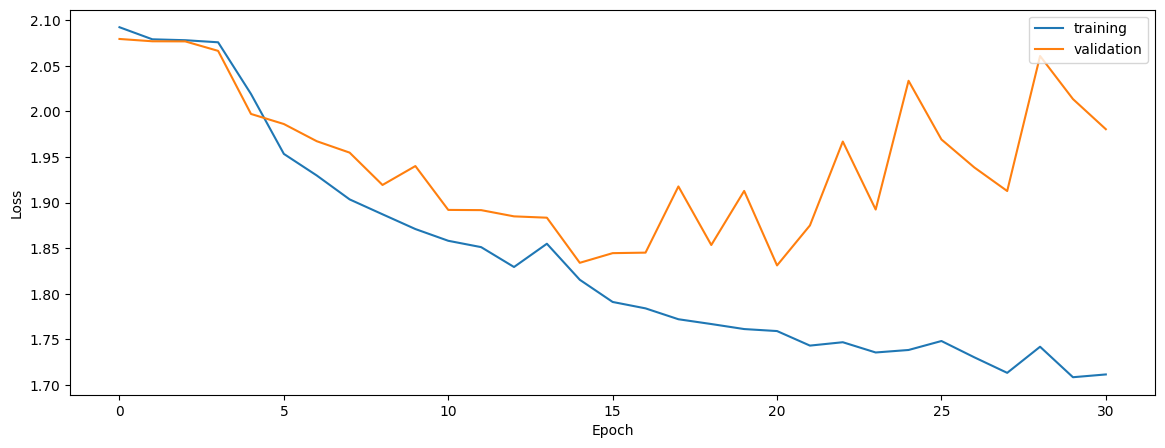

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASH))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('balanced')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

balanced


0.29853877329888207


0.26514894177510034


0.255630223219131


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('original')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

original


0.25357777066582077


0.3198425004791191


0.22145643996916103


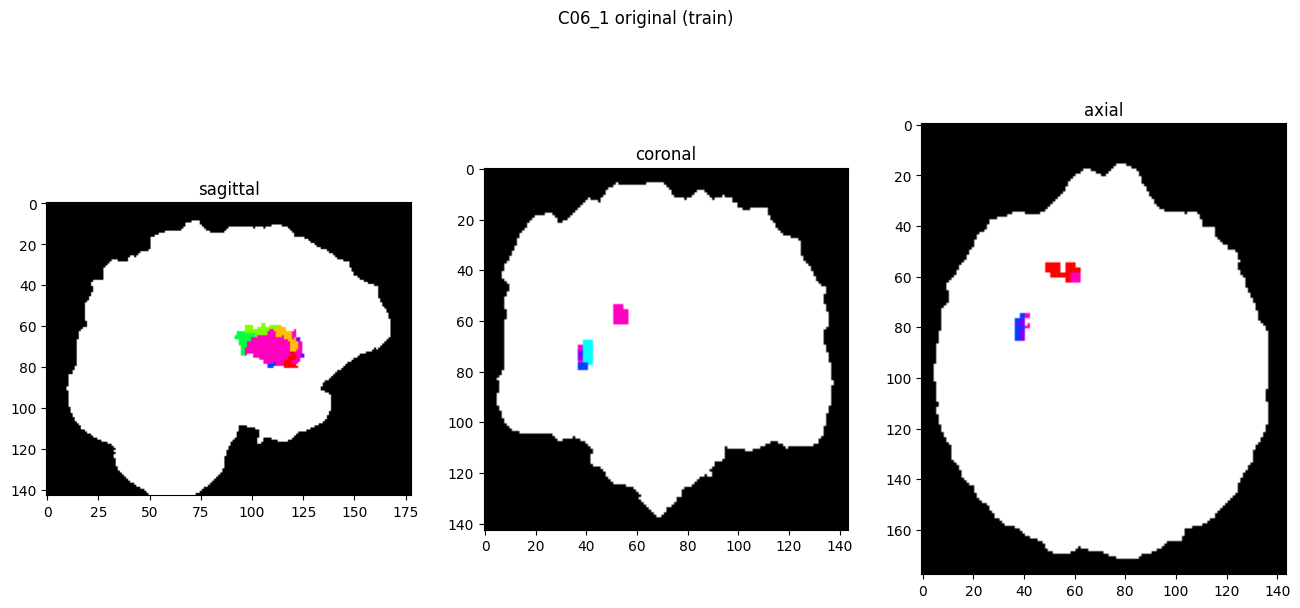

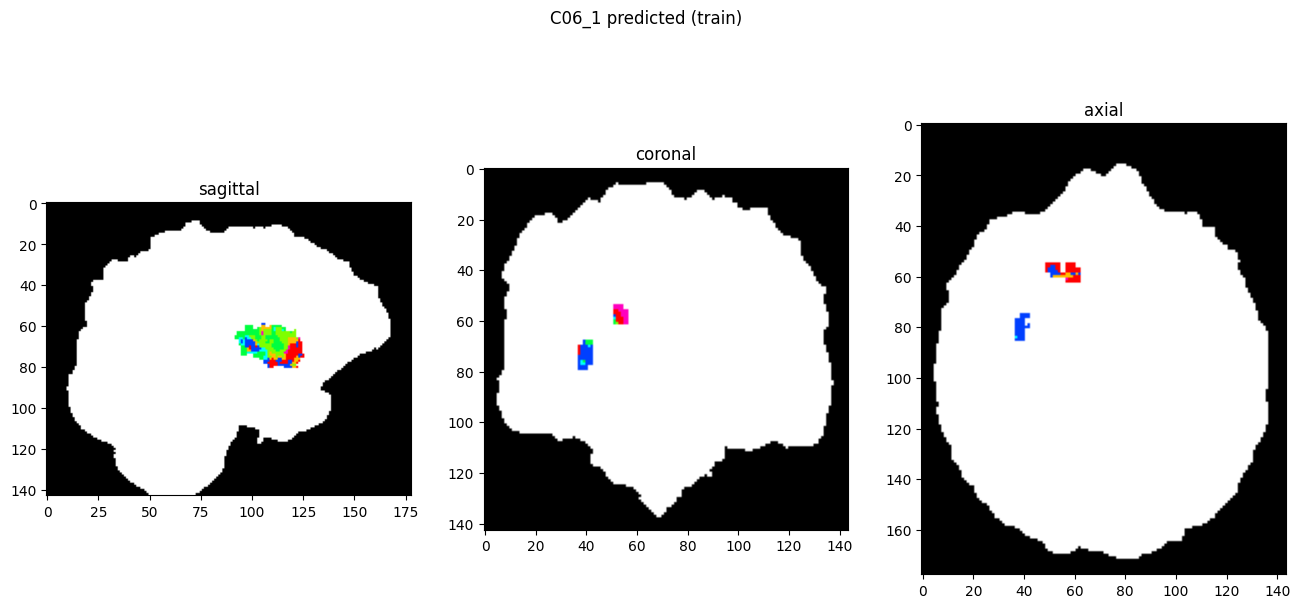

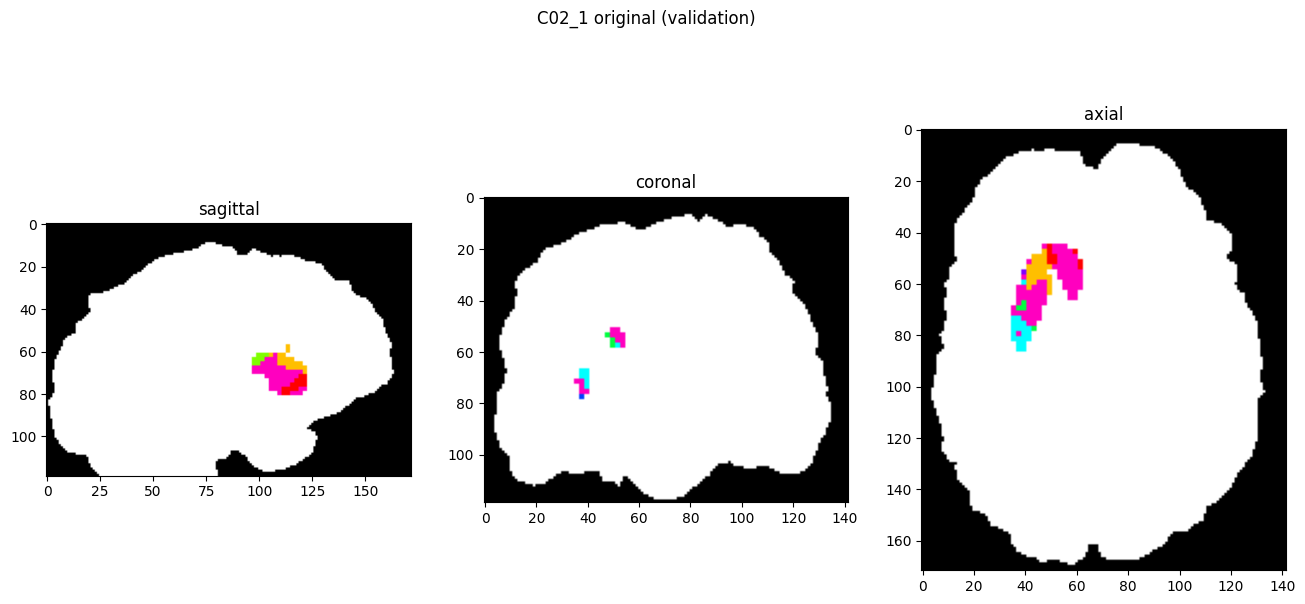

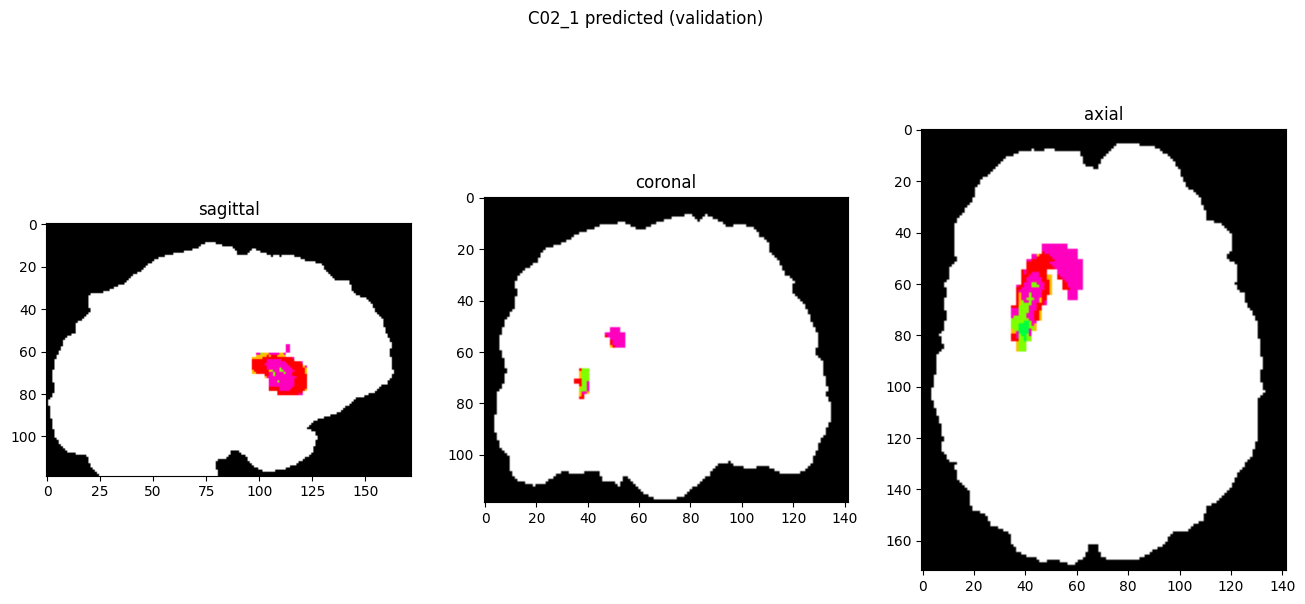

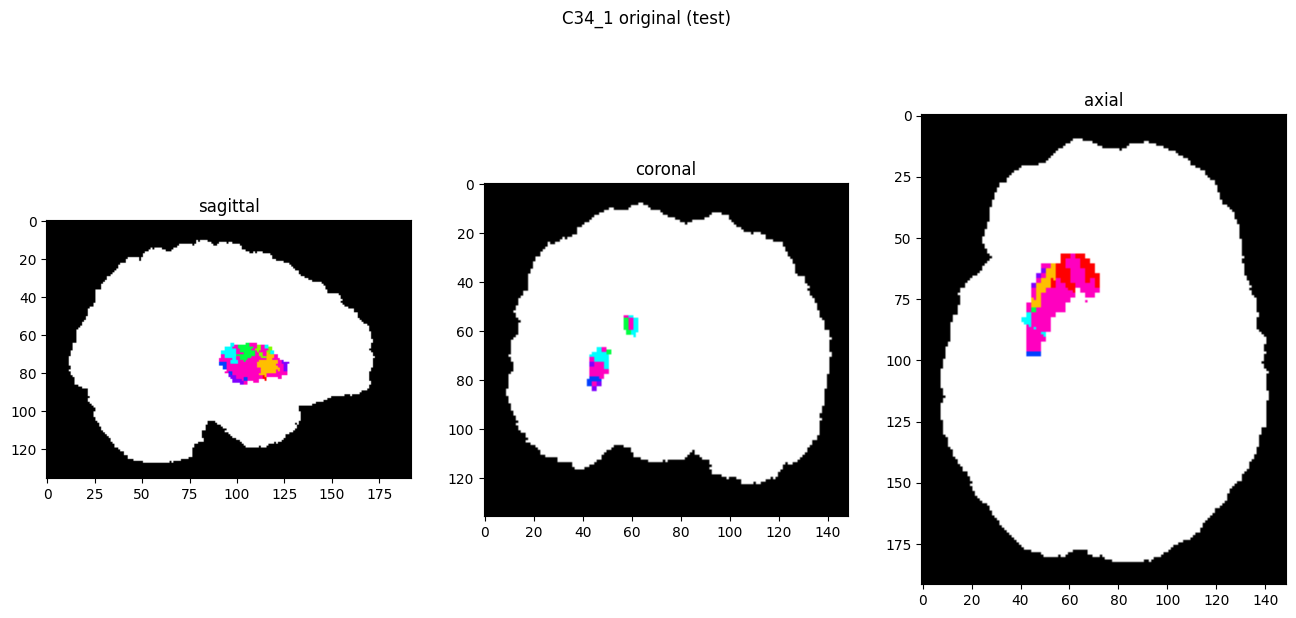

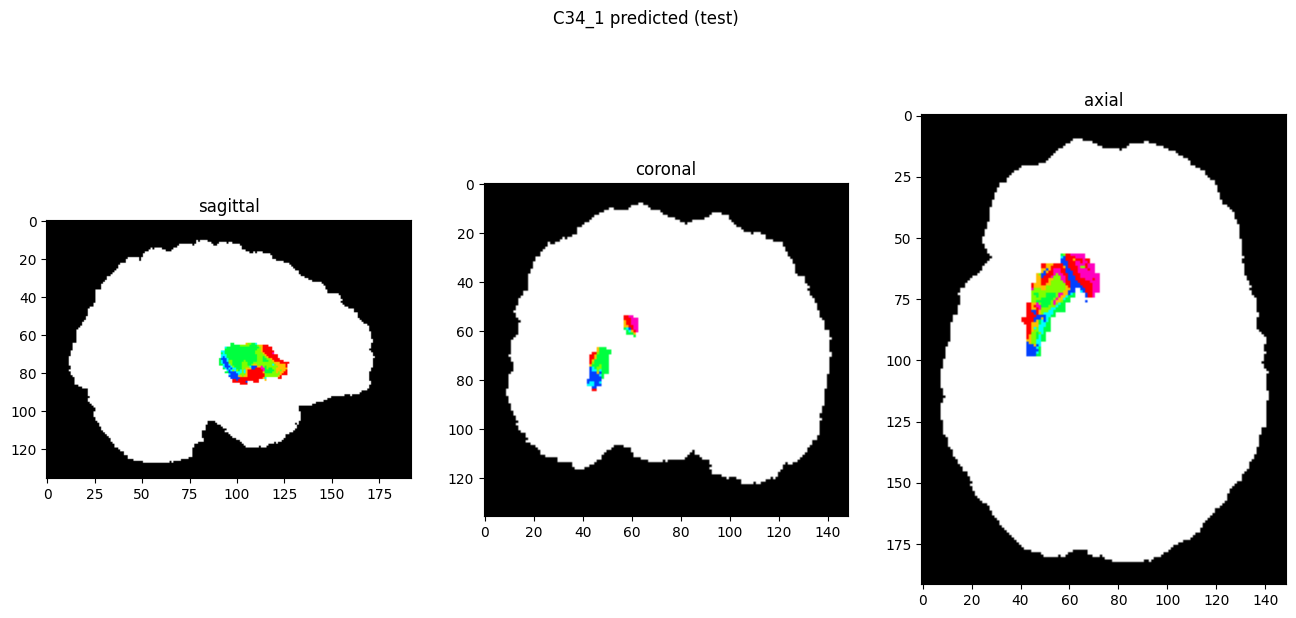

In [9]:
showResults(model, gen, threshold=0)